In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Virtual Laboratory/Virtual_Lab_02/iNeuron_DataScience/16_DL_Computer_Vision/BraTS/data

/content/drive/.shortcut-targets-by-id/1ybC2s2pso1TFHXle2VA2FLdjWbIDUtAc/Virtual_Lab_02/iNeuron_DataScience/16_DL_Computer_Vision/BraTS/data


In [4]:
!pip install scikit-image

In [5]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 301.1/301.1 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 82.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 71.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 92.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 115.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 119.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 128.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 70.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 3.3 MB/s eta 0:00

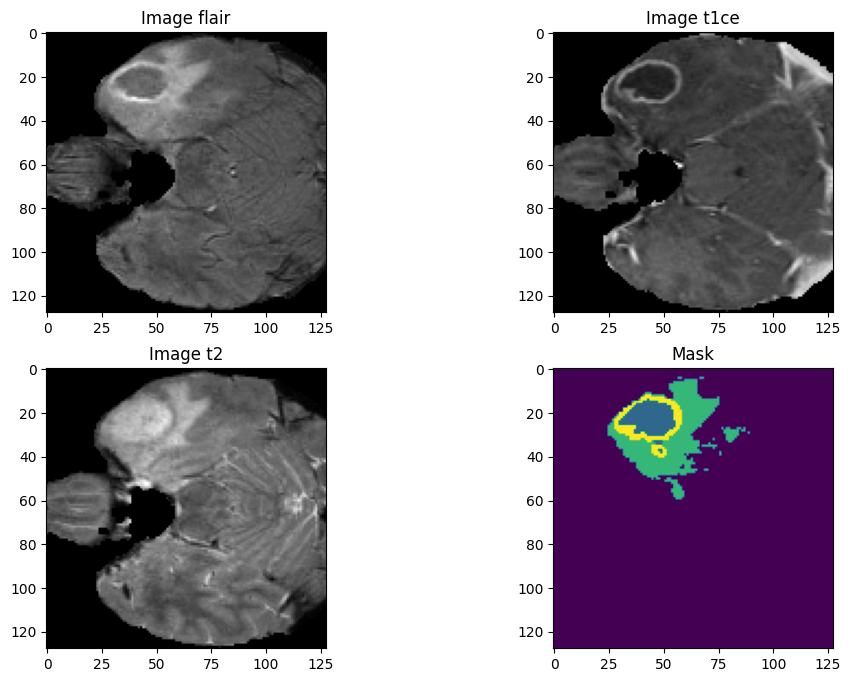

Segmentation Models: using `tf.keras` framework.


In [2]:
import os
import numpy as np
import pandas as pd
from custom_datagen import imageLoader
#import tensorflow as tf
import keras
from matplotlib import pyplot as plt
import glob
import random
import segmentation_models_3D as sm
from keras.models import load_model
from keras.metrics import MeanIoU
import tensorflow as tf



In [3]:
train_img_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/train/images/"
train_mask_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/train/masks/"

In [4]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [5]:
num_images = len(os.listdir(train_img_dir))

num_images

20

In [6]:
img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)

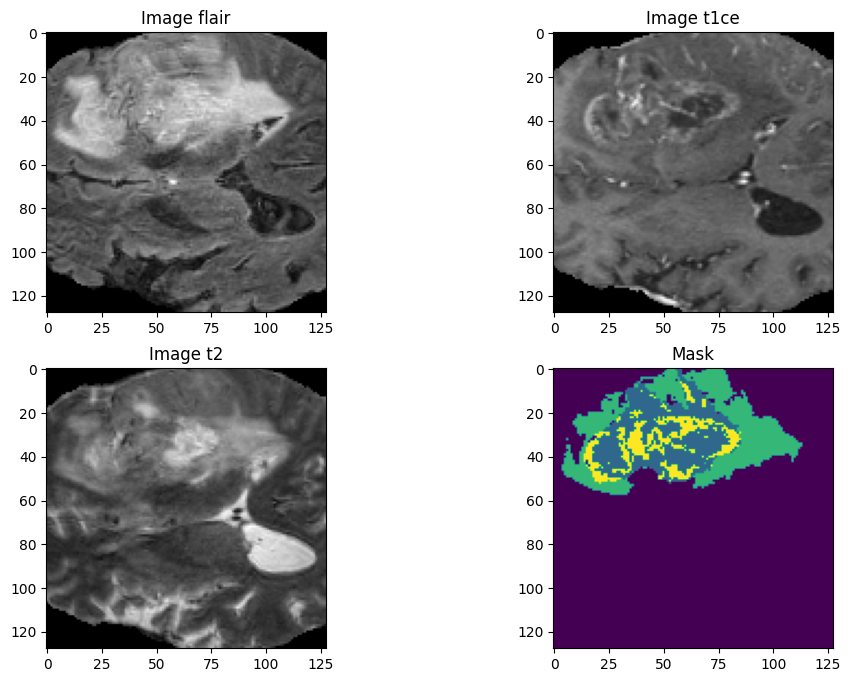

In [7]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()


In [8]:
#############################################################
#Optional step of finding the distribution of each class and calculating appropriate weights
#Alternatively you can just assign equal weights and see how well the model performs: 0.25, 0.25, 0.25, 0.25

import pandas as pd
columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('BraTS2020_DataSet/BraTS2020_numpy/data_split_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)


    df = df.append(conts_dict, ignore_index=True)


label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()

total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4

#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss

0


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


1


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


2


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


3


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


4


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


5


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


6


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


7


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)
<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


8
9


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


10


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


11


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


12


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


13


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


14


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


15


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


16


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


17


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


18


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


19


<ipython-input-8-20b1c738558d>:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(conts_dict, ignore_index=True)


In [9]:
#Define the image generators for training and validation

train_img_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/train/images/"
train_mask_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/train/masks/"

val_img_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/val/images/"
val_mask_dir = "BraTS2020_DataSet/BraTS2020_numpy/data_split_128/val/masks/"

In [10]:
train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [11]:
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list,
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list,
                                val_mask_dir, val_mask_list, batch_size)

In [12]:
#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()


In [13]:
img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

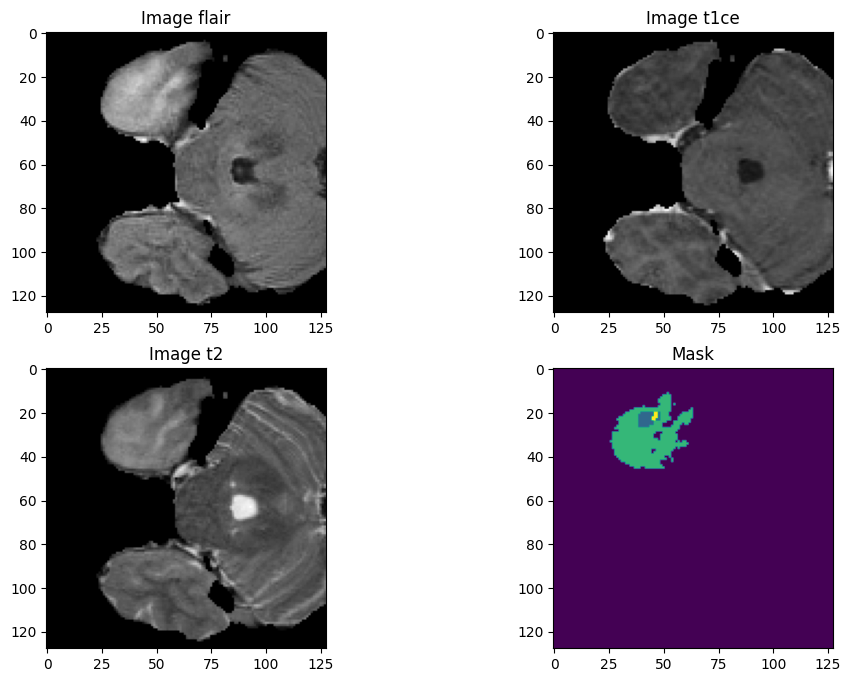

In [14]:
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')

os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/sample.png')
plt.show()

In [15]:
###########################################################################
#Define loss, metrics and optimizer to be used for training

wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

#import segmentation_models_3D as sm

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3]))
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001


#optim = keras.optimizers.Adam(LR) ########## Deprecated

optim = tf.keras.optimizers.Adam(LR)

In [16]:
#Fit the model

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size



from  simple_3d_unet import simple_unet_model

model = simple_unet_model(IMG_HEIGHT=128,
                          IMG_WIDTH=128,
                          IMG_DEPTH=128,
                          IMG_CHANNELS=3,
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

In [17]:
history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=50,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )


Epoch 1/50
10/10 [==============================] - 85s 7s/step - loss: 1.0048 - accuracy: 0.5156 - iou_score: 0.0608 - val_loss: 0.9891 - val_accuracy: 0.7943 - val_iou_score: 0.0570
Epoch 2/50
10/10 [==============================] - 22s 2s/step - loss: 0.9718 - accuracy: 0.8668 - iou_score: 0.1739 - val_loss: 0.9725 - val_accuracy: 0.9490 - val_iou_score: 0.1262
Epoch 3/50
10/10 [==============================] - 17s 2s/step - loss: 0.9598 - accuracy: 0.9469 - iou_score: 0.2080 - val_loss: 0.9696 - val_accuracy: 0.9573 - val_iou_score: 0.1313
Epoch 4/50
10/10 [==============================] - 15s 2s/step - loss: 0.9515 - accuracy: 0.9556 - iou_score: 0.2262 - val_loss: 0.9724 - val_accuracy: 0.9581 - val_iou_score: 0.0864
Epoch 5/50
10/10 [==============================] - 16s 2s/step - loss: 0.9458 - accuracy: 0.9572 - iou_score: 0.2329 - val_loss: 0.9658 - val_accuracy: 0.9581 - val_iou_score: 0.1183
Epoch 6/50
10/10 [==============================] - 15s 2s/step - loss: 0.9421 -

In [18]:
os.makedirs("./artifacts/models", exist_ok=True)

model.save('./artifacts/models/brats_3d.hdf5')

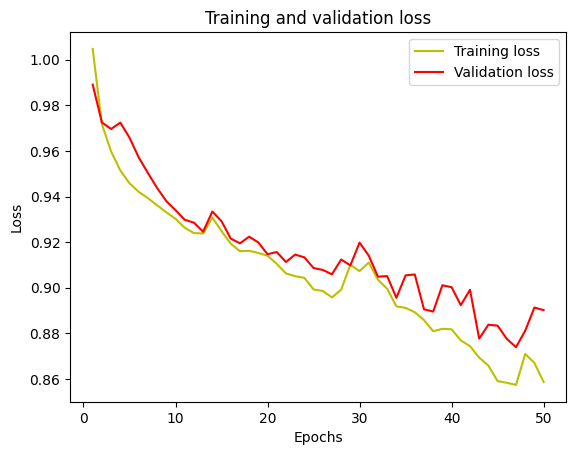

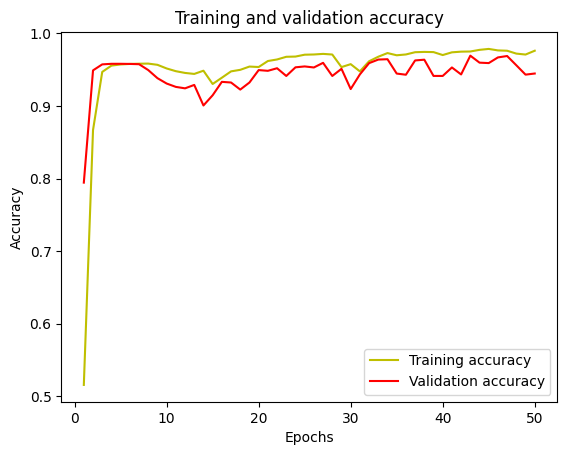

In [19]:
#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/loss.png')
plt.show()
plt.show()



acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/accuracy.png')
plt.show()

In [20]:
#from keras.models import load_model

#Load model for prediction or continue training

#For continuing training....
#The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
#This is because the model does not save loss function and metrics. So to compile and
#continue training we need to provide these as custom_objects.


my_model = load_model("/content/drive/MyDrive/Virtual Laboratory/Virtual_Lab_02/iNeuron_DataScience/16_DL_Computer_Vision/BraTS/data/artifacts/models/brats_3d.hdf5")

ValueError: ignored

In [ ]:
#So let us add the loss as custom object... but the following throws another error...
#Unknown metric function: iou_score


my_model = load_model('/content/drive/MyDrive/Virtual Laboratory/Virtual_Lab_02/iNeuron_DataScience/16_DL_Computer_Vision/BraTS/data/artifacts/models/brats_3d.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss})

In [34]:
#Now, let us add the iou_score function we used during our initial training


my_model = load_model('/content/drive/MyDrive/Virtual Laboratory/Virtual_Lab_02/iNeuron_DataScience/16_DL_Computer_Vision/BraTS/data/artifacts/models/brats_3d_v2.hdf5',
                      custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                      'iou_score':sm.metrics.IOUScore(threshold=0.5)})

In [35]:
#Now all set to continue the training process.


history2=my_model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=10,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

Epoch 1/10
10/10 [==============================] - 19s 2s/step - loss: 0.8280 - accuracy: 0.9816 - iou_score: 0.6060 - val_loss: 0.8671 - val_accuracy: 0.9638 - val_iou_score: 0.4781
Epoch 2/10
10/10 [==============================] - 15s 1s/step - loss: 0.8262 - accuracy: 0.9820 - iou_score: 0.6110 - val_loss: 0.8759 - val_accuracy: 0.9505 - val_iou_score: 0.4476
Epoch 3/10
10/10 [==============================] - 15s 2s/step - loss: 0.8248 - accuracy: 0.9820 - iou_score: 0.6164 - val_loss: 0.8893 - val_accuracy: 0.9367 - val_iou_score: 0.4121
Epoch 4/10
10/10 [==============================] - 15s 2s/step - loss: 0.8282 - accuracy: 0.9818 - iou_score: 0.6038 - val_loss: 0.8910 - val_accuracy: 0.9357 - val_iou_score: 0.4060
Epoch 5/10
10/10 [==============================] - 15s 2s/step - loss: 0.8401 - accuracy: 0.9784 - iou_score: 0.5577 - val_loss: 0.8759 - val_accuracy: 0.9477 - val_iou_score: 0.4487
Epoch 6/10
10/10 [==============================] - 14s 1s/step - loss: 0.8521 -

In [36]:
os.makedirs("./artifacts/models", exist_ok=True)

my_model.save('./artifacts/models/brats_3d_v3.hdf5')

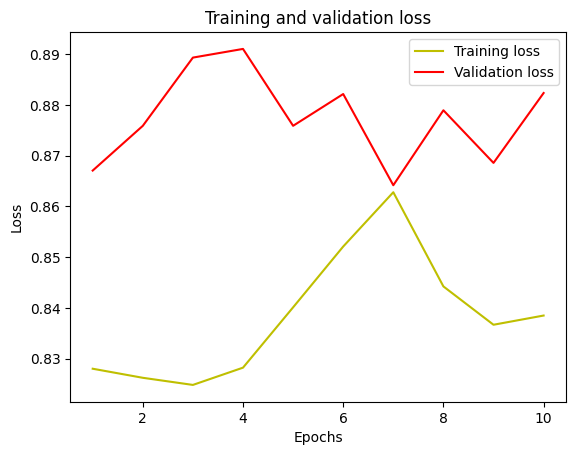

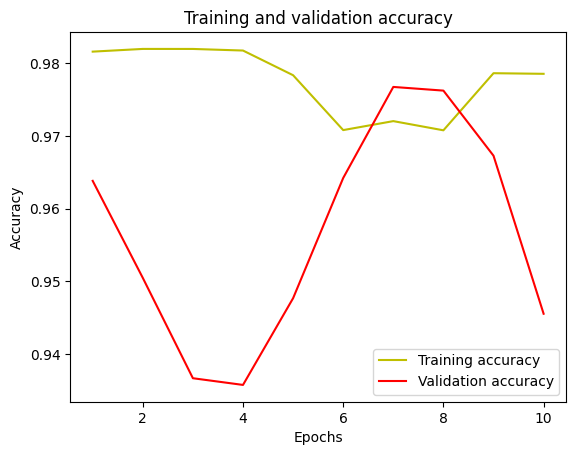

In [37]:
#plot the training and validation IoU and loss at each epoch
loss = history2.history['loss']
val_loss = history2.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/loss_3.png')
plt.show()
plt.show()



acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/accuracy_v3.png')
plt.show()

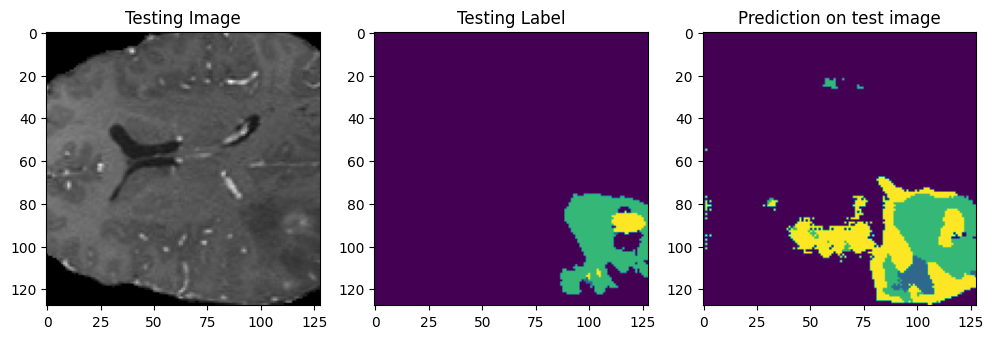

In [45]:

#########################    PREDICTION ON TEST DATA ####################

#Predict on a few test images, one at a time
#Try images:

img_num = 23


test_img = np.load("BraTS2020_DataSet/BraTS2020_numpy/data_split_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_DataSet/BraTS2020_numpy/data_split_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = my_model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


##########################################################################################

############# Plot individual slices from test predictions for verification

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 68
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])


os.makedirs("./artifacts/plots", exist_ok=True)
plt.savefig('./artifacts/plots/predictions_on_test_23.png')
plt.show()

############################################################

